In [1]:
using LinearAlgebra
using ForwardDiff
using Plots

In [2]:
# Parameters: Earth-Moon
m_earth = 5.9723*10^24 # mass of Earth (m1)
p_earth = 2360594.88 # period of Earth [s] 

m_moon = 0.07346*10^24 # mass of Moon (m2)
p_moon = 2360594.88 # period of Moon [s]

# Normalized Constants
m_total = m_earth + m_moon 
μ = (m_moon)/m_total

# μ = 1.215e-2 #gravitational parameter
μ1 = 1-μ
μ2 = μ

# Position of Earth and Moon
pose_m1 = [-μ, 0, 0] # Earth
pose_m2 = [1-μ, 0, 0] # Moon

# Position of Lagrange Points
L1 = [((1-(μ/3)^(1/3))), 0, 0];
L2 = [((1+(μ/3)^(1/3))), 0, 0];
L3 = [(-(1+(5*μ/12)^(1/3))), 0, 0];

L4 = [0.5-μ, sqrt(3)/2, 0];

L5 = [0.5-μ, -sqrt(3)/2, 0];

h_s = 100 #time step for RK4 in seconds # original 10 seconds
h_v = 100 #original 10 seconds

T = (p_earth + p_moon)/2 # average orbital period of Earth and Moon

time_scale = T/(2*pi)

# h_rk4 = h_s/time_scale #non dimensionalized time - original

# h_var = h_v/time_scale # original

h_rk4 = 0.01 # in report
h_var = 0.01 # in report

0.01

In [3]:
L2

3-element Vector{Float64}:
 1.159401690218366
 0.0
 0.0

In [4]:
function potential_energy(X)
    
     x = X[1]
     y = X[2]
     z = X[3]
    
     r1 = sqrt((x+μ2)^2 + y^2 + z^2) 
     r2 = sqrt((x-μ1)^2 + y^2 + z^2)
     #assuming m3 is unit mass
    
     U = (-μ1/r1)-(μ2/r2)-0.5*(μ1*μ2)
    
     return U
end

potential_energy (generic function with 1 method)

In [5]:
function effective_potential(X)
    
     x = X[1]
     y = X[2]
     z = X[3]
    
    
     r1 = sqrt((x+μ2)^2 + y^2 + z^2) 
     r2 = sqrt((x-μ1)^2 + y^2 + z^2)
     #assuming m3 is unit mass
    
    U = (-μ1/r1)-(μ2/r2)-0.5*(μ1*r1^2+μ2*r2^2) # working
    
     return U
end

effective_potential (generic function with 1 method)

In [6]:
#derivation for rotating
function three_body_prob_dynamics(x)
        
    q = x[1:3]
    v = x[4:6]
    a = zeros(3)
    
    U_q = (ForwardDiff.gradient(_x -> effective_potential(_x), q))
        
    a[1] = 2*v[2] - U_q[1] # original
    a[2] = -2*v[1] - U_q[2] # original
    a[3] = -U_q[3] # original 
    
    ẋ = [v; a] #x dot is velocity and acceleration
    
    return ẋ
end

three_body_prob_dynamics (generic function with 1 method)

In [7]:
function RK4_satellite_potential(x)

    f1 = three_body_prob_dynamics(x)
    f2 = three_body_prob_dynamics(x+0.5*h_rk4*f1)
    f3 = three_body_prob_dynamics(x+0.5*h_rk4*f2)
    f4 = three_body_prob_dynamics(x+h_rk4*f3)
    
    xnext = x+(h_rk4/6.0)*(f1+2*f2+2*f3+f4)
    
    return xnext
    
end

RK4_satellite_potential (generic function with 1 method)

In [8]:
one_min = 60/h_s #number of timesteps for 1 minute
min_day = 1440 #number of minutes this is a day
num_days = 3 #120 # 3 days original
t_f=num_days*min_day 
N = Int(one_min*t_f) #time steps for duration

print(N)

xk = zeros(6, N)

# Testing Initial Conditions
stable_perturbation_L1 = 1*[0.3556033994772462, 0.22411572113187364, 0, -0.767633822798689, -0.48379404700475315, 0]
unstable_perturbation_L1 =  0.05*[-0.35560339947724623, 0.22411572113187356,0, -0.767633822798689, 0.48379404700475315, 0]
stable_perturbation_L2 = 1e-1*[0.3556033994772462, 0.22411572113187364, 0,-0.767633822798689, -0.48379404700475315, 0]
stable_perturbation_4 = 1*[-0.21151685614932747, 8.69459011769262e-17, 0.0,-2.27583928070302e-16, 1.770870182281887, 1.795253414404434]
stable_eigen2 = [-0.30720121887787427, 2.155774426063215e-16, 0.0, -6.625394635729908e-16, 1.6666179843700804, 1.6571822780803005]

XL1 = [0.8369180073169304, 0, 0, 0, 0, 0]
XL2 = [1.1556799130947355, 0, 0, 0, 0, 0]

xk[:,1] = [1-μ, -0.0190, 0, 0.0263, 0.085, 0]


2592

6-element Vector{Float64}:
  0.9878493357328111
 -0.019
  0.0
  0.0263
  0.085
  0.0

In [9]:
for k=1:N-1
    
    xk[:,k+1] = RK4_satellite_potential(xk[:,k])
    
end

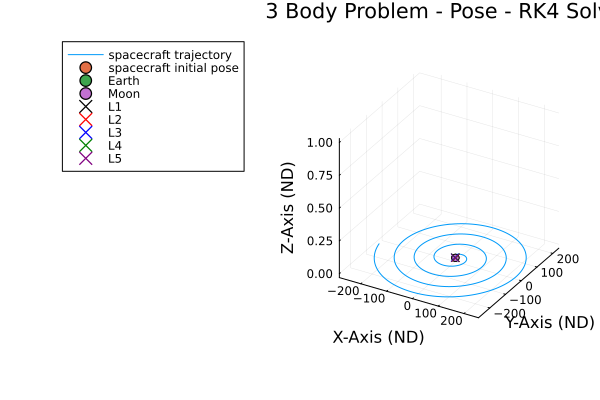

In [10]:
p0 = plot(xk[1,:], xk[2,:], xk[3,:], label = "spacecraft trajectory",  title="3 Body Problem - RK4 Solver", legend = :outertopleft)
scatter!([xk[1,1]], [xk[2,1]], [xk[3,1]], label="spacecraft initial pose")

scatter!([pose_m1[1]], [pose_m1[2]], [pose_m1[3]], label="Earth")
scatter!([pose_m2[1]], [pose_m2[2]], [pose_m2[3]], label="Moon")

plot!([L1[1]],[L1[2]], [L1[3]], label=string("L",1),markershape=:x,seriestype=:scatter,markercolor=:black)
plot!([L2[1]],[L2[2]], [L2[3]], label=string("L",2),markershape=:x,seriestype=:scatter,markercolor=:red)
plot!([L3[1]],[L3[2]], [L3[3]], label=string("L",3),markershape=:x,seriestype=:scatter,markercolor=:blue)
plot!([L4[1]],[L4[2]], [L4[3]], label=string("L",4),markershape=:x,seriestype=:scatter,markercolor=:green)
plot!([L5[1]],[L5[2]], [L5[3]], label=string("L",5),markershape=:x,seriestype=:scatter,markercolor=:purple)

# Plot Properties
xlabel!("X-Axis (ND)")
ylabel!("Y-Axis (ND)")
zlabel!("Z-Axis (ND)")
title!("3 Body Problem - Pose - RK4 Solver")

In [11]:
p1 = plot(xk[1,:], xk[2,:], label="spacecraft trajectory", legend = :outertopleft, xlims=(-1.5, 1.5), ylims=(-1.5,1.5))
scatter!([xk[1,1]], [xk[2,1]], label="spacecraft initial pose")

scatter!([pose_m1[1]], [pose_m1[2]], label="Earth")
scatter!([pose_m2[1]], [pose_m2[2]], label="Moon")

plot!([L1[1]],[L1[2]], label=string("L",1),markershape=:x,seriestype=:scatter,markercolor=:black)
plot!([L2[1]],[L2[2]], label=string("L",2),markershape=:x,seriestype=:scatter,markercolor=:red)
plot!([L3[1]],[L3[2]], label=string("L",3),markershape=:x,seriestype=:scatter,markercolor=:blue)
plot!([L4[1]],[L4[2]], label=string("L",4),markershape=:x,seriestype=:scatter,markercolor=:green)
plot!([L5[1]],[L5[2]], label=string("L",5),markershape=:x,seriestype=:scatter,markercolor=:purple)

# Plot of the Lagrange Points


# Plot Properties
xlabel!("X-Axis (ND)")
ylabel!("Y-Axis (ND)")
# title!("3 Body Problem - Pose - RK4 Solver")

savefig("3_body_RK4")

"C:\\Users\\frc-ag-2\\Documents\\MSR Curriculum\\Fall 2022\\16715_Robot_Dynamics\\Final Project\\final_project\\src\\3_body_RK4.png"

In [12]:
kinetic_E = 0.5*(xk[4,:].*xk[4,:] + xk[5,:].*xk[5,:] + xk[6,:].*xk[6,:])

2592-element Vector{Float64}:
     0.003958345
     0.10713830147412838
     0.7839987455297106
    65.45837803898792
    65.32078695372505
    65.30943887427613
    65.31611577960373
    65.3247421094848
    65.32798290332886
    65.32263375759666
    65.30919946077782
    65.29114223167234
    65.27344592047635
     ⋮
 36678.703215749854
 36707.1771835847
 36735.66221837779
 36764.15832012895
 36792.66548883804
 36821.18372450494
 36849.71302712948
 36878.25339671152
 36906.80483325093
 36935.36733674754
 36963.94090720124
 36992.52554461187

In [13]:
potential_E = zeros(N)

#find the potential energy at each time step
for i=1:N
    
    X = [xk[1,i], xk[2,i], xk[3,i]]
    potential_E[i] = effective_potential(X)
    
end

In [14]:
#plotting the total energy in the system
total_energy = kinetic_E + potential_E

2592-element Vector{Float64}:
 -2.117326545697687
 -2.1171918325302665
 -2.0835582444119947
 63.76443277751349
 63.7567809443347
 63.75670357300615
 63.75669773550615
 63.756697225066844
 63.756697266619646
 63.75669699902309
 63.75669641395647
 63.75669582137386
 63.75669545233597
  ⋮
 63.75669569566526
 63.756695695650706
 63.75669569566526
 63.756695695650706
 63.75669569564343
 63.75669569564343
 63.756695695650706
 63.75669569562888
 63.756695695636154
 63.75669569562888
 63.75669569562888
 63.756695695614326

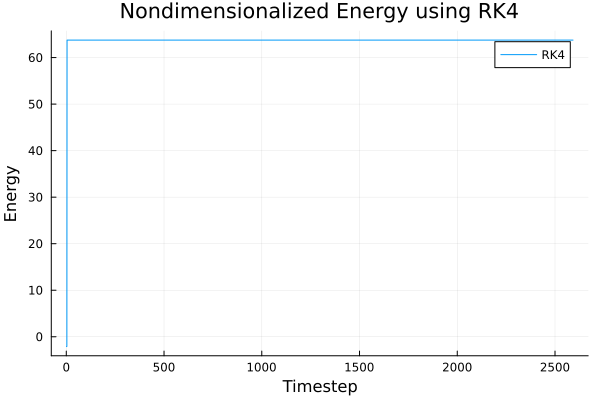

In [15]:
plot(1:N, total_energy, xlabel="Timestep", ylabel = "Energy", label= "RK4", title="Nondimensionalized Energy using RK4" )

In [16]:
function Lagrangian(q,v)
    x = q[1]
    y = q[2]
    z = q[3]
    
    dx = v[1]
    dy = v[2]
    dz = v[3]
    
    r1 = sqrt((x+μ2)^2 + y^2 + z^2) 
    r2 = sqrt((x-μ1)^2 + y^2 + z^2)
    
    L = 0.5*((dx-y)^2 + (dy+x)^2 + dz^2) - (-μ1/r1)-(μ2/r2)-0.5*(μ1*μ2)
    return L
end

Lagrangian (generic function with 1 method)

In [17]:
function Ld_pose(q1,q2)
    qm = 0.5*(q1 + q2)
    vm = (q2-q1)/h_var
    return h_var*Lagrangian(qm,vm)
end

Ld_pose (generic function with 1 method)

In [18]:
function DLT1(q1,q2)
    
    r1 = q1[1:3]
    r2 = q2[1:3]    
    right_Legendre = ForwardDiff.gradient(dr1 -> Ld_pose(dr1,r2), r1)
    
    return right_Legendre
end

DLT1 (generic function with 1 method)

In [19]:
function DLT2(q1,q2)
    r1 = q1[1:3]
    r2 = q2[1:3]
    left_Legendre = ForwardDiff.gradient(dr2 -> Ld_pose(r1,dr2), r2)

    return left_Legendre
end

DLT2 (generic function with 1 method)

In [20]:
function DEL(q1,q2,q3)   
    
    DEL = DLT2(q1,q2) + DLT1(q2,q3)
    
    return DEL
end

DEL (generic function with 1 method)

In [21]:
# working original
m3 = 1
#simulate using a midpoint variational integrator

#initial conditions for variational integrator (working)
#r0 = [0.75, 0.01]
#v0 = [0.01, 0.085]

#initial conditions for variational integrator (testing)
# r0 = stable_perturbation_4[1:3] # working previously
# v0 = stable_perturbation_4[4:6] # working previously

r0 = [1-μ, -0.0190, 0]
v0 = [0.0263, 0.085, 0]

p0 = m3*v0

qhist = zeros(3,N)
phist = zeros(3,N)
#using RK4 sol (kinda working)
#qhist[:,1] .= xk[1:2,1]
#qhist[:,2] .= xk[1:2,2]

qhist[:,1] .= r0
#qhist[:,2] .= r0+(h_var.*v0)

#initialize momentumm
phist[:,1] .= p0

max_iterations = 20
tol = 1e-10

#for q1 and q2 initialize
#for k = 2:(N-1)

#for momentum initialize
for k = 1:(N-1)

#for k = 2:5
    
    qhist[:,k+1] .= qhist[:,k] #initial guess
    
    for i=1:max_iterations
        
        #e = DEL(qhist[:,k-1], qhist[:,k], qhist[:,k+1]) #DEL residual
        
        e = phist[:,k]+DLT1(qhist[:,k],qhist[:,k+1]) #residual for momentum as input
        
        if norm(e)<tol
            break
            
        end
    
        #jacobian = ForwardDiff.jacobian(dqhist-> DEL(qhist[:,k-1], qhist[:,k], dqhist), qhist[:,k+1])
               
        jacobian = ForwardDiff.jacobian(dqhist-> DLT1(qhist[:,k], dqhist), qhist[:,k+1])
        
        delta_q = jacobian\-e
            
        nextpose = qhist[:, k+1]+delta_q
        
        qhist[:,k+1] = nextpose
        
    end
    
    #udpate momentum (left discrete Legendre transform)
    phist[:,k+1] = DLT2(qhist[:,k],qhist[:,k+1])
    
    
end

vhist = phist./m3

3×2592 Matrix{Float64}:
 0.0263   0.0161046   0.00405507  …  -0.327553  -0.312933  -0.298284
 0.085   -0.125227   -0.224779        1.45943    1.46256    1.46554
 0.0      0.0         0.0             0.0        0.0        0.0

[0.9878493357328111, -0.019, 0.0]

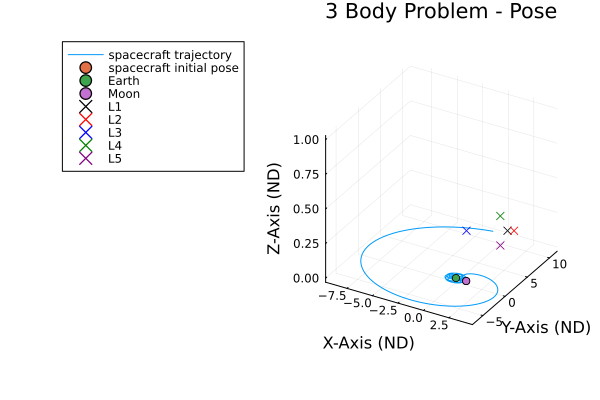

In [22]:
plot(qhist[1,:], qhist[2,:], qhist[3,:], label="spacecraft trajectory", legend = :outertopleft)
scatter!([qhist[1,1]], [qhist[2,1]], [qhist[3,1]], label="spacecraft initial pose")

print(qhist[:,1])

scatter!([pose_m1[1]], [pose_m1[2]], [pose_m1[3]], label="Earth")
scatter!([pose_m2[1]], [pose_m2[2]], [pose_m2[3]], label="Moon")

plot!([L1[1]],[L1[2]], label=string("L",1),markershape=:x,seriestype=:scatter,markercolor=:black)
plot!([L2[1]],[L2[2]], label=string("L",2),markershape=:x,seriestype=:scatter,markercolor=:red)
plot!([L3[1]],[L3[2]], label=string("L",3),markershape=:x,seriestype=:scatter,markercolor=:blue)
plot!([L4[1]],[L4[2]], label=string("L",4),markershape=:x,seriestype=:scatter,markercolor=:green)
plot!([L5[1]],[L5[2]], label=string("L",5),markershape=:x,seriestype=:scatter,markercolor=:purple)

xlabel!("X-Axis (ND)")
ylabel!("Y-Axis (ND)")
zlabel!("Z-Axis (ND)")
title!("3 Body Problem - Pose")

In [23]:
plot(qhist[1,:], qhist[2,:], label="spacecraft trajectory", legend = :outertopleft, xlims=(-1.5, 1.5), ylims=(-1.5,1.5))
scatter!([qhist[1,1]], [qhist[2,1]], label="spacecraft initial pose")

scatter!([pose_m1[1]], [pose_m1[2]], label="Earth")
scatter!([pose_m2[1]], [pose_m2[2]], label="Moon")

plot!([L1[1]],[L1[2]], label=string("L",1),markershape=:x,seriestype=:scatter,markercolor=:black)
plot!([L2[1]],[L2[2]], label=string("L",2),markershape=:x,seriestype=:scatter,markercolor=:red)
plot!([L3[1]],[L3[2]], label=string("L",3),markershape=:x,seriestype=:scatter,markercolor=:blue)
plot!([L4[1]],[L4[2]], label=string("L",4),markershape=:x,seriestype=:scatter,markercolor=:green)
plot!([L5[1]],[L5[2]], label=string("L",5),markershape=:x,seriestype=:scatter,markercolor=:purple)

xlabel!("X-Axis (ND)")
ylabel!("Y-Axis (ND)")
# title!("3 Body Problem - Pose")

savefig("3_body_variational_var")

"C:\\Users\\frc-ag-2\\Documents\\MSR Curriculum\\Fall 2022\\16715_Robot_Dynamics\\Final Project\\final_project\\src\\3_body_variational_var.png"

In [24]:
potential_E_var = zeros(N)

#find the potential energy at each time step
for i=1:N
    
    X_var = [qhist[1,i], qhist[2,i], qhist[3,i]]
    potential_E_var[i] = effective_potential(X_var)
    
end


In [25]:
potential_E_var

2592-element Vector{Float64}:
  -2.121284890697687
  -1.8996223411076718
  -1.7802722116959706
  -1.7105885841363275
  -1.6660454447327098
  -1.6354801898007532
  -1.6133497360641293
  -1.5966527598171711
  -1.583642141221802
  -1.573238996758839
  -1.5647441266772588
  -1.557685940058947
  -1.551735563870192
   ⋮
 -61.79494744303262
 -61.96050514481015
 -62.12627829423434
 -62.292266878584286
 -62.458470885177874
 -62.62489030137163
 -62.79152511456049
 -62.958375312177616
 -63.12544088169409
 -63.29272181061891
 -63.460218086498514
 -63.627929696916794

In [26]:
#momentum is the velocity in this case since we assume m3 is unit mass

#kinetic energy of the spacecraft at each time step

kinetic_E_var = 0.5*(vhist[1,:].*vhist[1,:] + vhist[2,:].*vhist[2,:] + vhist[3,:].*vhist[3,:])

2592-element Vector{Float64}:
 0.003958345
 0.00797054887922959
 0.02527100548496685
 0.03910362459315069
 0.04925218281171448
 0.05681485150136798
 0.06263854552295277
 0.06728026198402416
 0.07110244826769667
 0.074345779508482
 0.07717445738848375
 0.0797036013191768
 0.08201599791316799
 ⋮
 1.119663347693853
 1.1195455478832474
 1.1194280732714008
 1.1193109225194056
 1.1191940942954113
 1.1190775872741614
 1.118961400137683
 1.1188455315745052
 1.1187299802798125
 1.1186147449559911
 1.1184998243117874
 1.1183852170626334

In [27]:
#plotting the total energy in the system
total_E_var = kinetic_E_var + potential_E_var

2592-element Vector{Float64}:
  -2.117326545697687
  -1.8916517922284422
  -1.7550012062110039
  -1.6714849595431769
  -1.6167932619209953
  -1.5786653382993852
  -1.5507111905411766
  -1.5293724978331469
  -1.5125396929541053
  -1.4988932172503568
  -1.487569669288775
  -1.4779823387397701
  -1.469719565957024
   ⋮
 -60.67528409533877
 -60.8409595969269
 -61.00685022096294
 -61.17295595606488
 -61.339276790882465
 -61.505812714097466
 -61.67256371442281
 -61.83952978060311
 -62.00671090141428
 -62.174107065662916
 -62.341718262186724
 -62.50954447985416

In [28]:
plot(1:N, total_E_var, xlabel="Timestep", ylabel = "Energy", label= "Variational", title="Nondimensionalized Energy", linecolor="red")
plot!(1:N, total_energy, label= "RK4", linecolor="green")
xlabel!("Timestep")
ylabel!("Energy")
title!("Nondimensionalized Energy")

savefig("energy_compared")

"C:\\Users\\frc-ag-2\\Documents\\MSR Curriculum\\Fall 2022\\16715_Robot_Dynamics\\Final Project\\final_project\\src\\energy_compared.png"